In [1]:
import json
import pandas as pd
import common

In [2]:
word_list = []
with open(r"word_list\english\frequency_list.txt", encoding="utf-8") as file:
    for line in file.readlines():
        items = line.split()
        *words, count = items
        word = " ".join(words)
        word_list.append([word, int(count)])
print(word_list[:5])

[['the', 18399669358], ['of', 12042045526], ['be', 9032373066], ['and', 8588851162], ['to', 7305545226]]


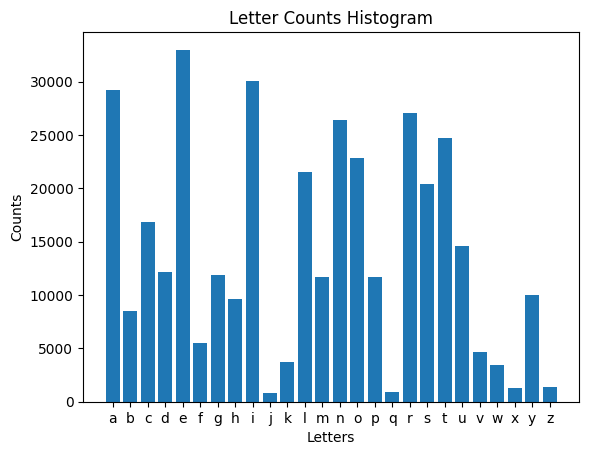

all alphabets: abcdefghijklmnopqrstuvwxyz
non_alphas: 
less_than_10: 
outliers: 
remainings: abcdefghijklmnopqrstuvwxyz


In [3]:
df = pd.DataFrame(word_list)
df.columns = ["word", "count"]
common.plot_count_graph(df)
common.analyze_alphabets(df)

In [4]:
# only lowercase word
df["word"] = df["word"].apply(lambda x: str(x).lower())
agg_functions = {"word": "first", "count": "sum"}
df = df.groupby(df["word"], as_index=False).aggregate(agg_functions)

# allowed alphabets
allowed_alphabets = "abcdefghijklmnopqrstuvwxyz"
df = df[df["word"].str.contains(f"^[{allowed_alphabets}]+$")]

# frequent words
df = df[df["count"] > df["count"].quantile(0.1)]

df["word_len"] = df["word"].apply(len)
df = df.sort_values(by=["word"]).reset_index(drop=True)
df.head()

,word,count,word_len
0,a,6394255549,1
1,aachen,1996,6
2,aaron,1259,5
3,aba,68071,3
4,ababa,1298,5


In [5]:
df.dtypes

word        object
count        int64
word_len     int64
dtype: object

In [6]:
df.describe()

,count,word_len
count,4.802800e+04,48028.000000
mean,5.069854e+06,8.225327
std,1.329803e+08,2.652167
min,5.880000e+02,1.000000
25%,1.273050e+04,6.000000
50%,9.478500e+04,8.000000
75%,6.230600e+05,10.000000
max,1.839967e+10,29.000000


In [7]:
df.query("count > 10000 and word_len >= 3 and word_len <= 5").describe()

,count,word_len
count,6.281000e+03,6281.000000
mean,1.903572e+07,4.393727
std,2.728925e+08,0.699102
min,1.000400e+04,3.000000
25%,8.981000e+04,4.000000
50%,5.074540e+05,5.000000
75%,3.416571e+06,5.000000
max,1.839967e+10,5.000000


In [8]:
df[(df["word_len"] >= 4) & (df["word_len"] <= 5) & (df["count"] > 10000)].describe()

,count,word_len
count,5.496000e+03,5496.000000
mean,1.254375e+07,4.592795
std,8.408108e+07,0.491358
min,1.000400e+04,4.000000
25%,8.462700e+04,4.000000
50%,4.711435e+05,5.000000
75%,3.238747e+06,5.000000
max,3.246059e+09,5.000000


In [9]:
df.query("'deceive' in word or 'deceived' in word")

,word,count,word_len
10828,deceive,4596724,7


In [10]:
difficulties = {"easy": 0.6, "medium": 0.4, "hard": 0.2, "all": 0}
min_len = 4
max_len = 5

for name, base_percentile in difficulties.items():
    dfs_filtered: list[pd.DataFrame] = []
    lengths: list[str] = []
    for l in range(min_len, max_len + 1):
        df_len = df[df["word_len"] == l]
        # longer words need larger vocab pool
        # percentile = max(base_percentile - (l - min_len) * 0.05, 0)
        percentile = base_percentile
        cutoff = df_len["count"].quantile(percentile)
        dfs_filtered.append(
            df_len[df_len["count"] > cutoff]
            .sort_values(by=["count"], ascending=False)
            .reset_index(drop=True)
        )
        lengths.append(f"len{l}: #{len(dfs_filtered[-1])}")
    df_filtered = pd.concat(dfs_filtered)

    print(", ".join(lengths))

    with open(rf"vocabs\en\en-{name}.json", "w") as f:
        data = df_filtered["word"].sort_values().tolist()
        json.dump(data, f)
        print(f"{f.name}: {len(df_filtered)} words")

len4: #1004, len5: #1571
vocabs\en\en-easy.json: 2575 words
len4: #1506, len5: #2356
vocabs\en\en-medium.json: 3862 words
len4: #2008, len5: #3141
vocabs\en\en-hard.json: 5149 words
len4: #2509, len5: #3925
vocabs\en\en-all.json: 6434 words
